In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import random
import glob
import pickle
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm

import sklearn

import tensorflow as tf
import tf_data


In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [6]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [7]:
_load_n_items = 10
_batch_size = 5
_nepochs = 100
_ntrain = 10000
_nval = 1000

In [8]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features, _batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds) 

In [9]:
X,y = tf_data.get(total_ds)

# Graph building layer

In [37]:
from model import *
from plotting import * 

In [11]:
graph = GraphBuilding(output_dim_nodes=64)

In [12]:
cl_x, coord, adj, mask = graph(X[0],X[1])

In [13]:
mask

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0.]], dtype=float32)>

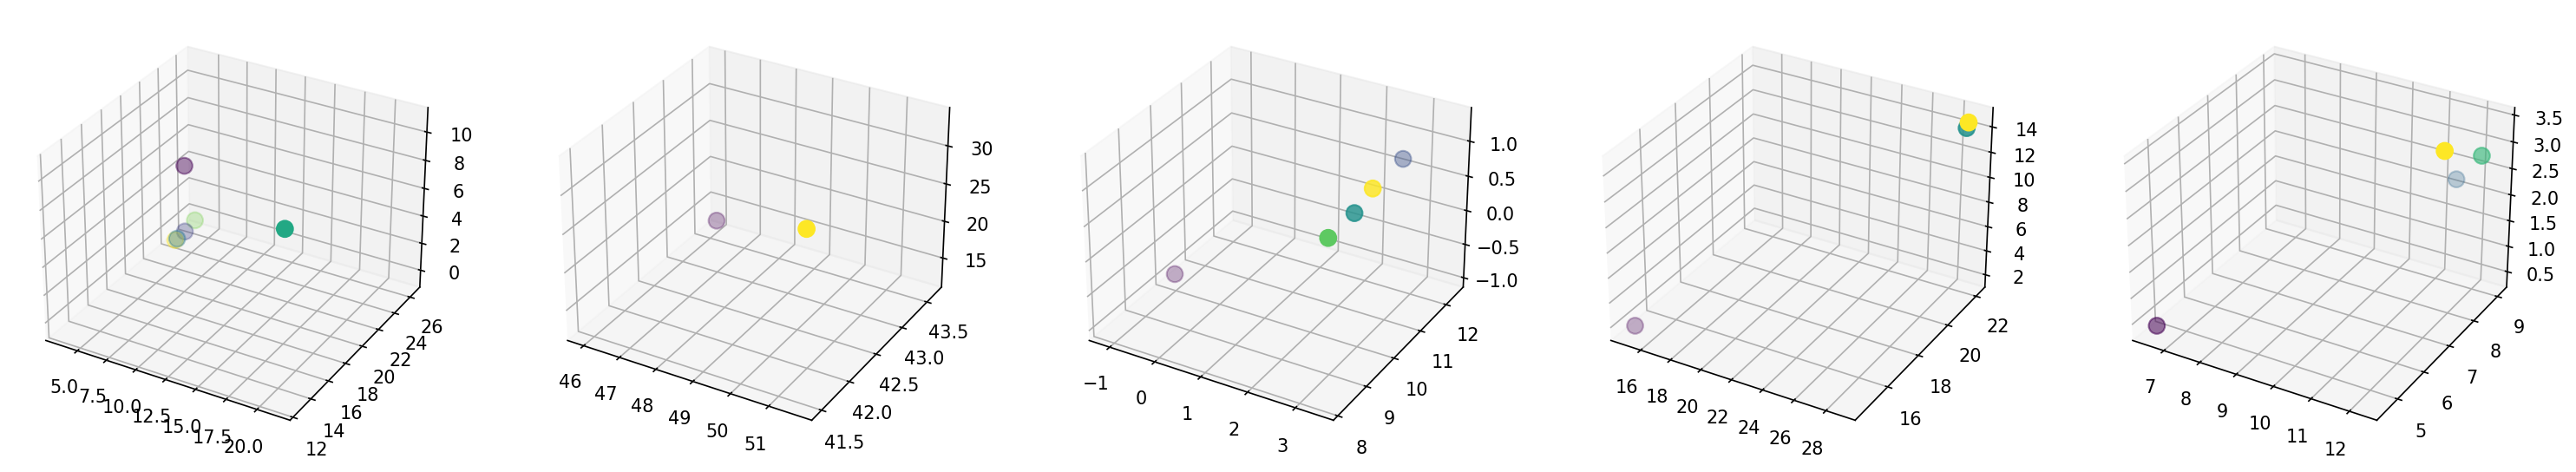

In [15]:
plot3D(coord, mask)

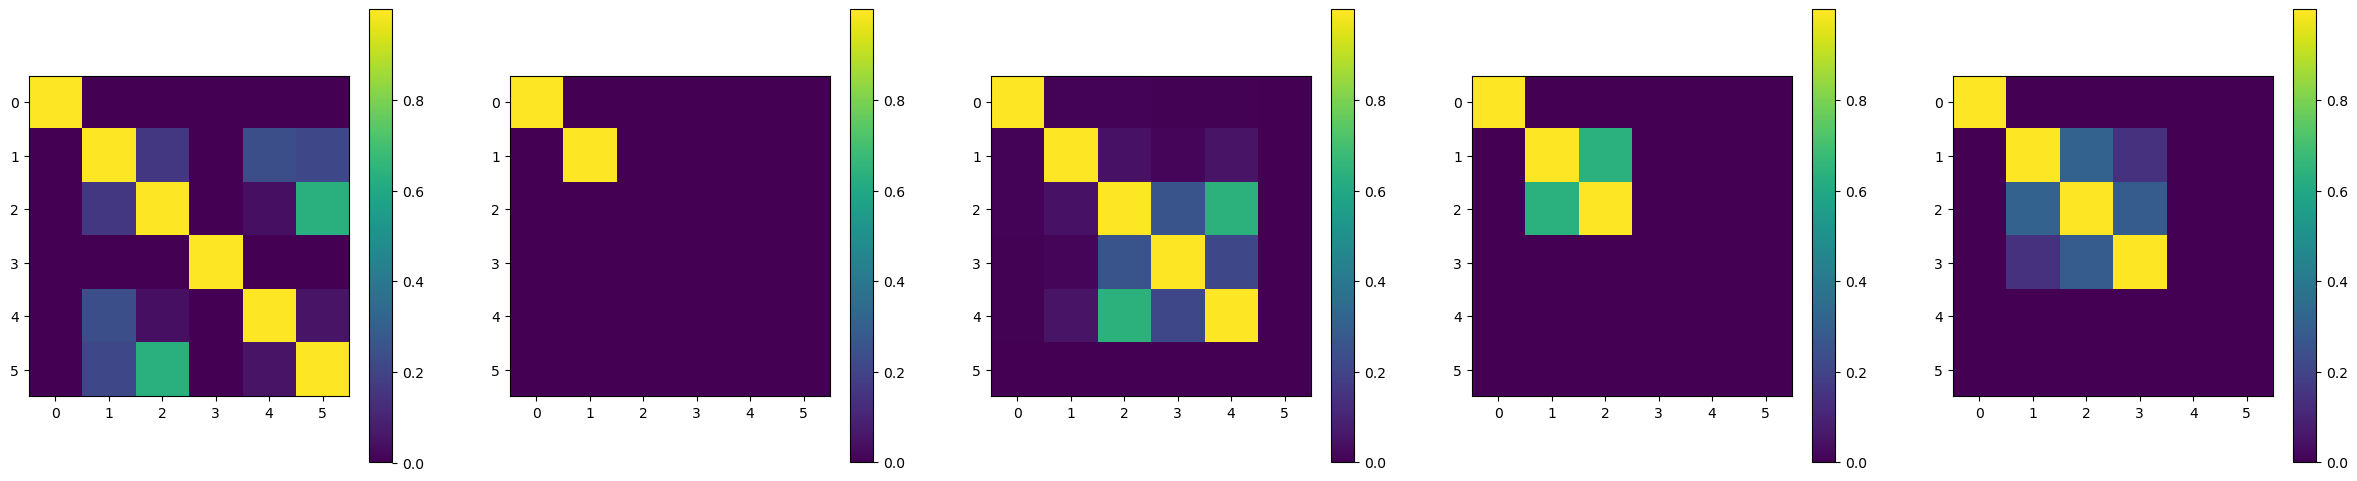

In [16]:
plotM(*adj)

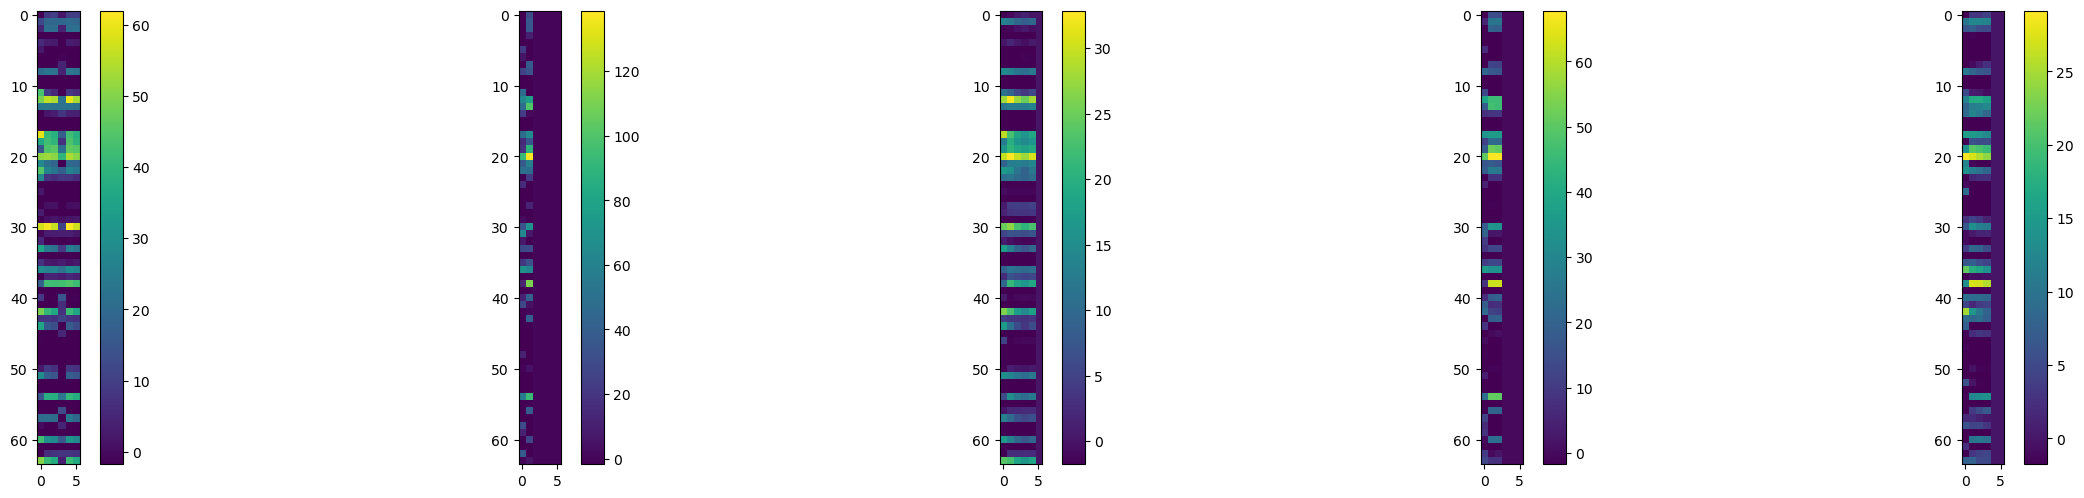

In [17]:
plotM(*cl_x)

# Complete model

In [18]:
help(DeepClusterGN)

Help on class DeepClusterGN in module model:

class DeepClusterGN(tensorflow.python.keras.engine.training.Model)
 |  DeepClusterGN(*args, **kwargs)
 |  
 |  Model parameters:
 |  - activation
 |  - output_dim_nodes: latent space dimension for clusters node built from rechits and cluster features
 |  - output_dim_rechits:  latent space dimension for the rechits per-cluster feature vector
 |  - output_dim_gconv: output of the graph convolution
 |  - output_dim_clclass: output of the self-attention layer for cluster classification
 |  - coord_dim:  coordinated space dimension
 |  - nconv_rechits: number of convolutions for the rechits GCN
 |  - nconv: number of convolutions for the global model
 |  - layers_input:  list representing the DNN applied on the [rechit+cluster] concatened features to build the clusters latent space
 |  - layers_coord:  list representing the DNN applied on the clusters latent space to extract the coordinated
 |  - layers_clclass:  list representing the DNN for c

In [51]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=64, output_dim_gconv=128, output_dim_clclass=21 )

In [59]:
dense_clclass_X, mask_cls = model(X)

In [52]:
dense_clclass, mask_cls, (cl_X, coord, adj ,out_gcn, out_SA) = dcgn(X)

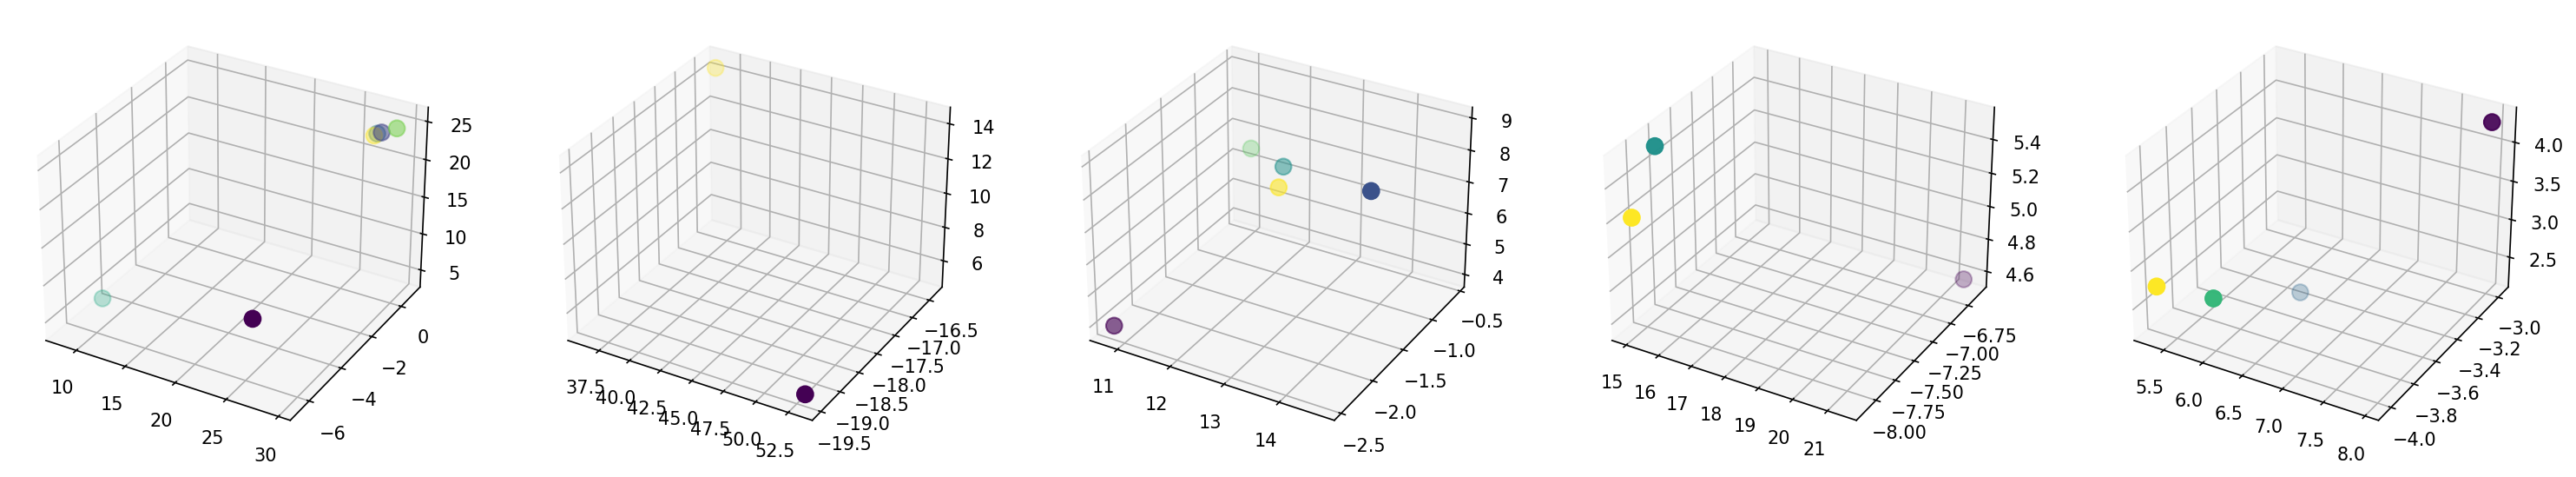

In [43]:
plot3D(coord, mask)

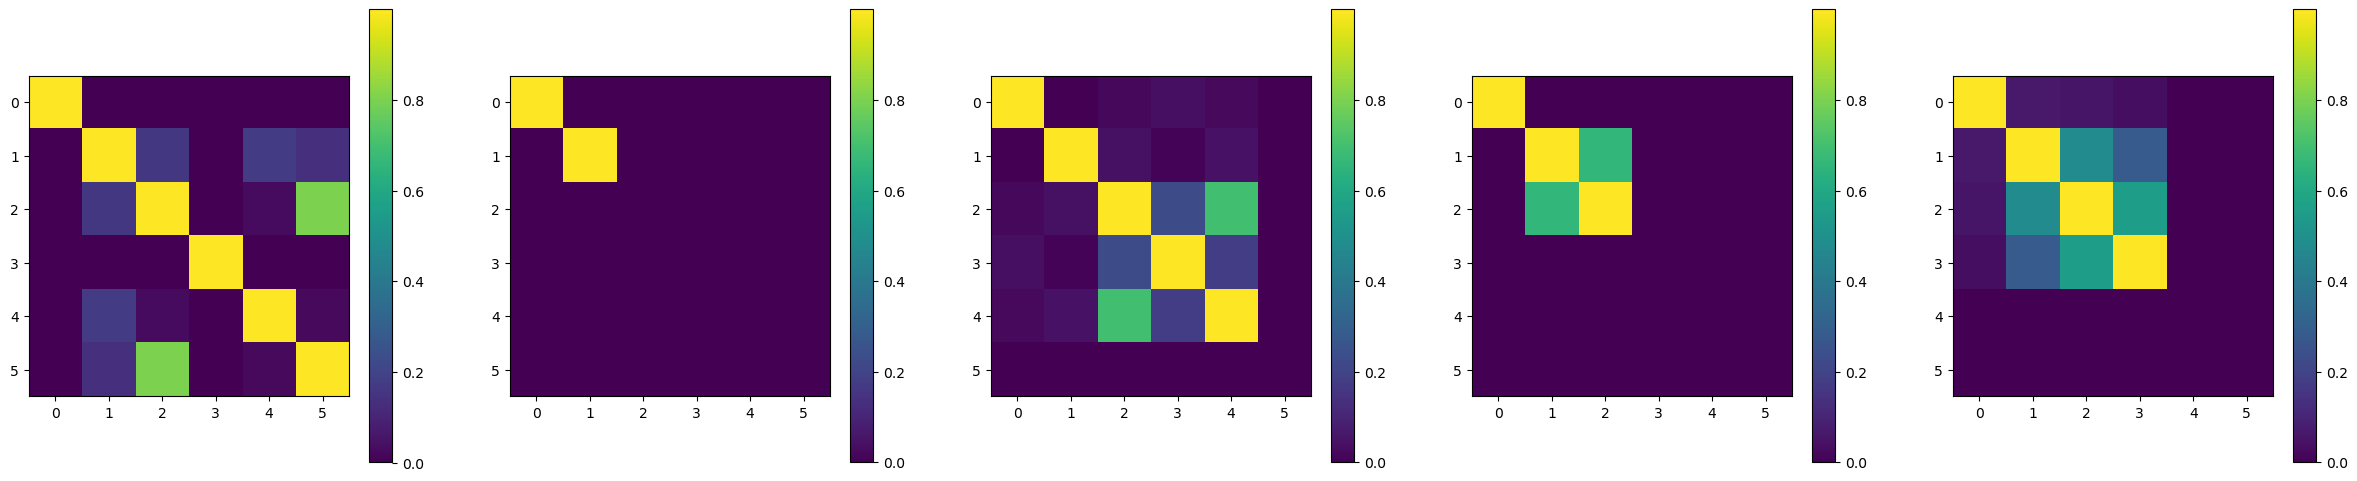

In [44]:
plotM(*adj)

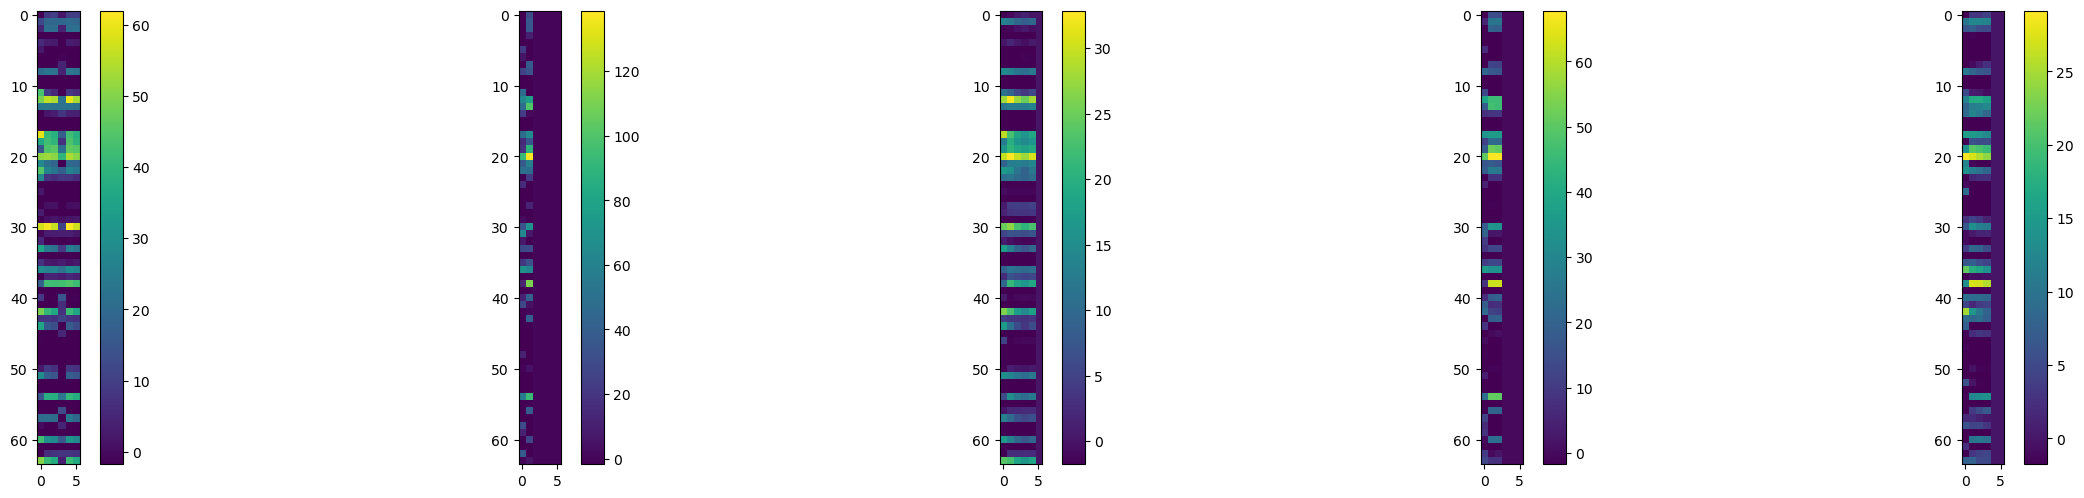

In [45]:
plotM(*cl_x)

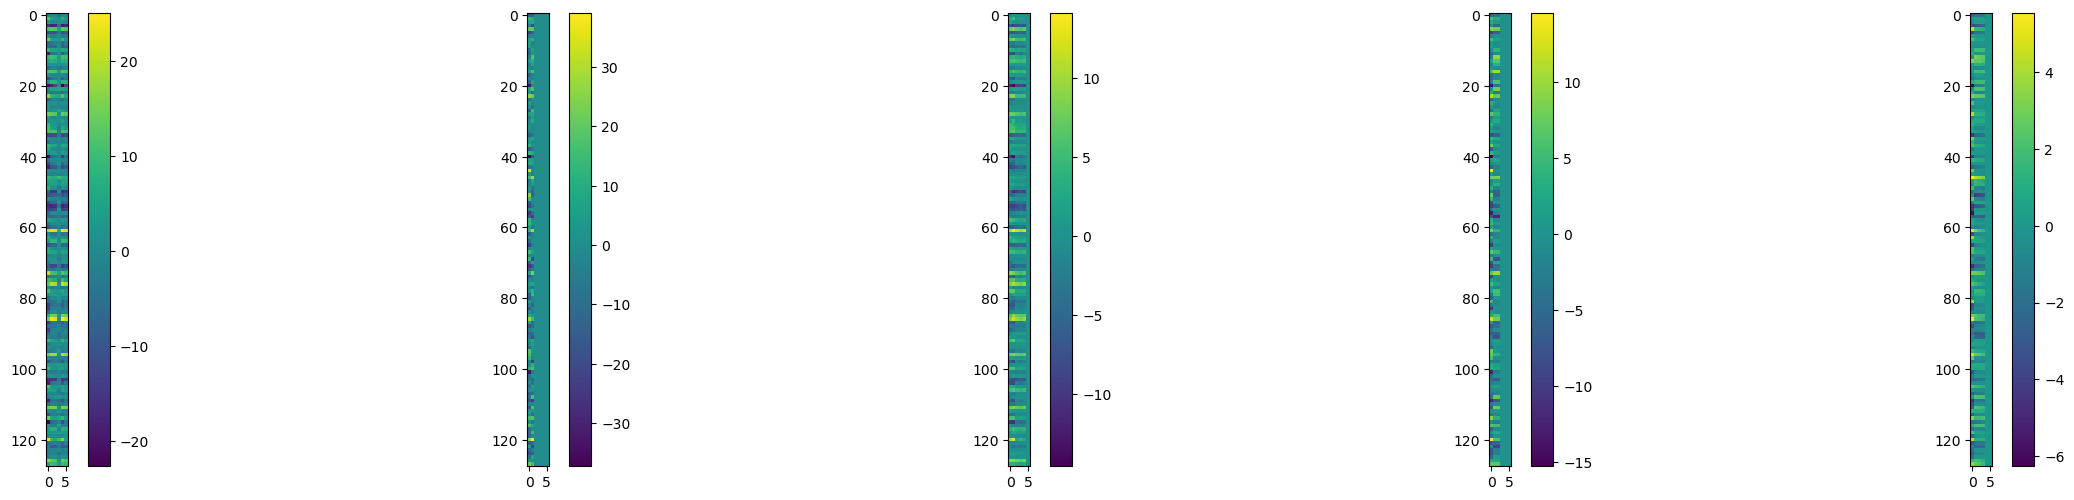

In [46]:
plotM(*out_gcn)

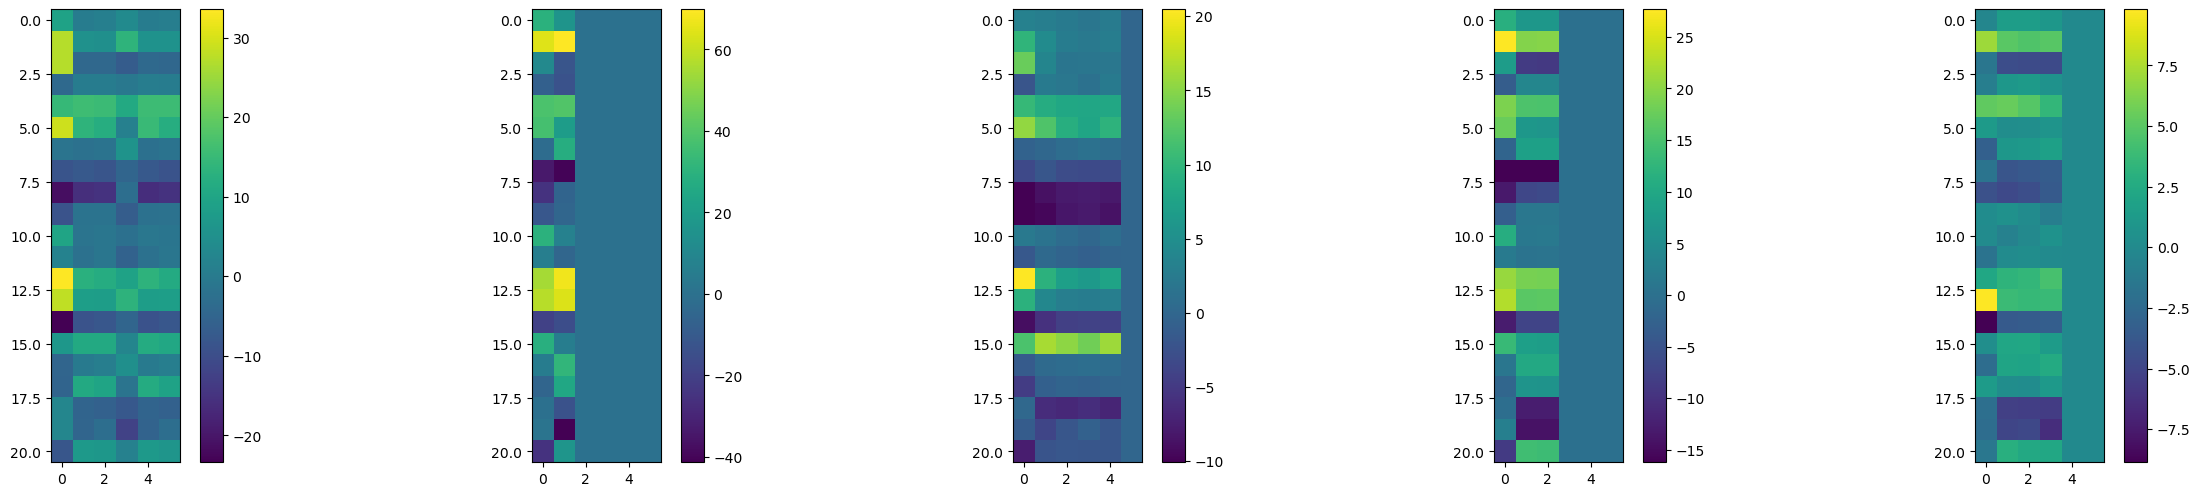

In [53]:
plotM(*out_SA)

# Loss function

In [24]:
tf.keras.losses.binary_crossentropy(y[0], clclass, from_logits=True)

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[1.2544693e+00, 1.6726814e-01, 1.7022898e+00, 2.3558130e-03,
        1.7844741e+00, 1.7896304e+00],
       [1.9950013e+00, 1.8689686e+00, 2.5588481e+00, 2.1619809e+00,
        2.4825170e+00, 6.9314718e-01],
       [2.7252929e+00, 7.8578969e-04, 6.9314718e-01, 6.9314718e-01,
        6.9314718e-01, 6.9314718e-01],
       [4.9877777e+00, 8.9786746e-02, 6.7233354e-02, 4.2795710e-02,
        6.9314718e-01, 6.9314718e-01],
       [1.2305492e+00, 1.8673058e+00, 1.0937862e+00, 1.2275174e+00,
        6.9314718e-01, 6.9314718e-01]], dtype=float32)>

In [30]:
dense_clclass, mask_cls = dcgn(X)

In [35]:
tf.keras.losses.binary_crossentropy(y[0], dense_clclass, from_logits=True) * mask_cls

<tf.Tensor: shape=(5, 6), dtype=float32, numpy=
array([[0.60862964, 0.78548735, 0.        , 0.        , 0.        ,
        0.        ],
       [0.60204124, 0.7956555 , 0.7958472 , 0.        , 0.        ,
        0.        ],
       [1.0814037 , 1.0811594 , 0.4145223 , 0.4250816 , 0.41418827,
        0.4145932 ],
       [0.5850257 , 0.8203548 , 0.8215989 , 0.82283866, 0.        ,
        0.        ],
       [0.37433124, 1.1638608 , 1.1639353 , 1.1639781 , 0.        ,
        0.        ]], dtype=float32)>

In [106]:
def custom_loss(y_true, y_pred):
    dense_clclass = y_pred[0]
    mask_cls  = y_pred[1]
    y_class = y_true[0]
    y_metadata = y_true[1]
    
    tf.print("y_class: " , y_class.shape)
    tf.print("y_matadata: " , y_metadata.shape)
    tf.print("y_true", y_true)
    tf.print("y_pred", y_pred)
    
    class_loss = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls
    reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-1))
    return reduced_loss 

In [101]:
custom_loss(y, dcgn(X))

y_class:  TensorShape([70, 17, 1])
y_matadata:  TensorShape([70, 3])


<tf.Tensor: shape=(), dtype=float32, numpy=4.873573>

# Test training

In [19]:
from model import *
from plotting import * 

In [17]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'debug'])


args = Args( 
models_path = models_path,
load = False,
nepochs = 100,
ntrain = 1000,
nval = 100,
# nfeatures = 13,
# n_seed_features = 12,
lr_decay = 0,
lr = 1e-2,
batch_size = 30,
# n_layers_input = 3,
# n_layers_id = 3,
# n_layers_coord = 3,
# hidden_dim_input = 200,
# hidden_dim_coord = 200,
# hidden_dim_id = 200,
# distance_dim = 200,
# num_conv = 2,
# dropout = 0.2,
# convlayer = 'sgconv',
# nclass_labels=2,
opt='adam',
debug = False
        )

### Dataset loading

In [8]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_06


In [9]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [10]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [27]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features, args.batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds).prefetch(200)

ds_train = total_ds.take(args.ntrain).repeat(args.nepochs)
ds_test  = total_ds.skip(args.ntrain).take(args.nval).repeat(args.nepochs)

In [12]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay
        )
else:
    lr_schedule = args.lr


In [20]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = DeepClusterGN(nconv=3, output_dim_nodes=32, debug=args.debug)

In [21]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=0
)
cp_callback.set_model(model)
callbacks += [cp_callback]





In [22]:
with strategy.scope():
    model.compile(optimizer=args.opt)
#         metrics=[Precision(),Recall(), energy_resolution_insc,energy_resolution_outsc,
#                      energy_resolution_insc_log,energy_resolution_outsc_log,])
    model.set_metrics()

    for X, y in ds_train:
        ypred = model(X)
        #l = custom_loss(y, ypred)
        break

    

In [15]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_building (GraphBuildin multiple                  15875     
_________________________________________________________________
gh_conv_i_1 (GHConvI)        multiple                  2080      
_________________________________________________________________
self_attention (SelfAttentio multiple                  5184      
_________________________________________________________________
dense_9 (Dense)              multiple                  2112      
_________________________________________________________________
dense_10 (Dense)             multiple                  4160      
_________________________________________________________________
dense_11 (Dense)             multiple                  65        
_________________________________________________________________
loss (Mean)                  multiple              

In [25]:
args.ntrain//args.batch_size

33

In [23]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
#         callbacks = callbacks
    )

Epoch 1/100
33/33 [==============================] - 431s 13s/step - loss: 3.2937 - val_loss: 2.2815
Epoch 2/100
33/33 [==============================] - 437s 13s/step - loss: 2.5324 - val_loss: 1.9006
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 2.2812

KeyboardInterrupt: 

In [79]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
#OLd model
